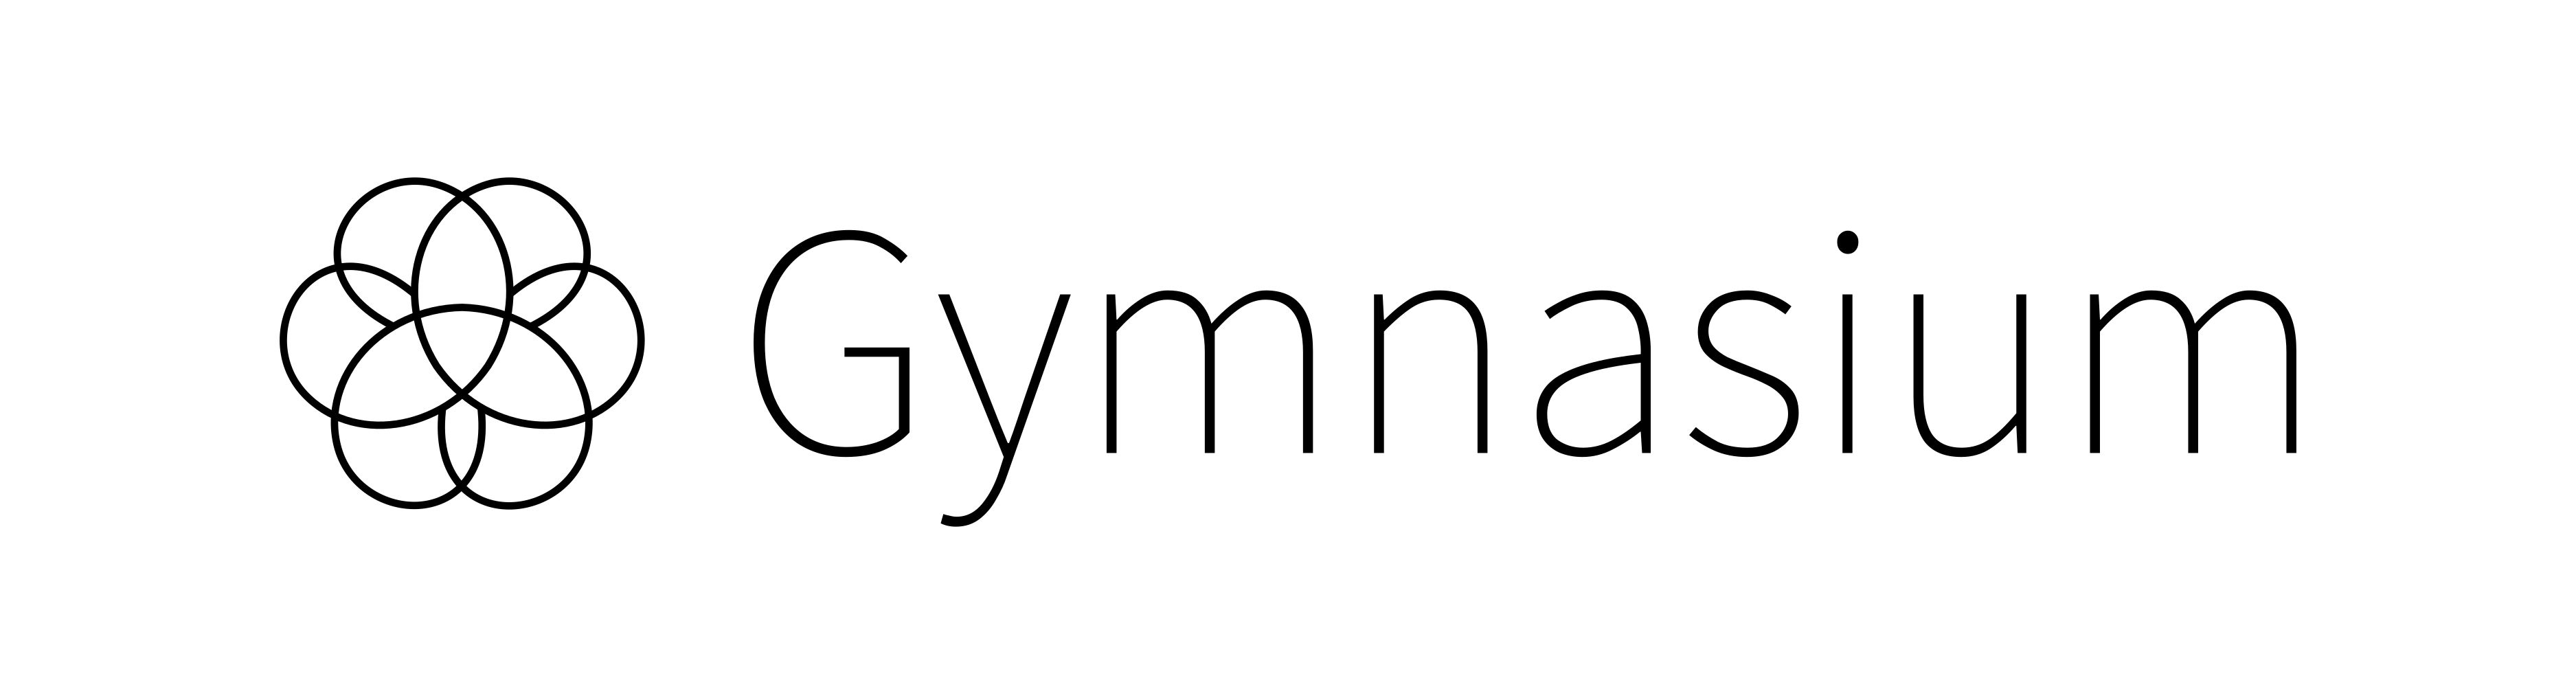

In this notebook i'll try to solve OpenAI's Lunar Lander environment using a custom made Double Deep Q-Network. I'll be using Tensorflow for the model itself, though pytorch could of course also be used.


In [1]:
import random
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from collections import deque
import tensorflow as tf
import numpy as np
import gymnasium as gym
import keras
import matplotlib.pyplot as plt

# Classes

In [2]:
class Transition:
    
    def __init__(self, state, action, reward, next_state, terminated):
        
        self.state = state
        self.action = action
        self.reward = reward
        self.next_state = next_state
        self.terminated = terminated
        
        self.data = [self.state, self.action, self.reward, self.next_state, self.terminated]
        
    def __repr__(self):
        
        return f"Transition{self.data}"
    
    def __iter__(self):
        
        return iter(self.data)
    
    def __getitem__(self, item):
        
         return self.data[item]

In [3]:
class Memory:
    
    def __init__(self, capacity):
        
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def store(self, transition):
        
        self.memory.append(transition)

    def sample(self, batch_size):
        
        batch = random.sample(self.memory, batch_size)
        return batch

In [4]:
class Agent:
    
    def __init__(self, policy, memory, batch_size, update_frequency, env, tau, gamma):

        self.policy = policy
        self.memory = memory
        self.batch_size = batch_size
        self.update_frequency = update_frequency
        self.env = env
        self.tau = tau
        self.gamma = gamma
        self.rewards = []


    def select_action(self, state):
        
        return self.policy.select_action(state)
        
    def train(self, batch_size):
        
        """
        Train the model using a batch of transitions to update the Q-values.

        This function updates the neural network model by taking a batch of transitions from memory and
        calculating the Q-value targets for those transitions, then using them to adjust the Q-values
        for the corresponding actions. It follows the DQN training process.

        :param batch_size: The number of random transitions to use in each training iteration.
        """
        
        # making sure the program doesn't crash when there aren't any memories
        if batch_size > len(self.memory.memory):
            return
        
        batch = self.memory.sample(batch_size)
                        
        states = np.array([transition[0] for transition in batch])
        actions = np.array([transition[1] for transition in batch])
        rewards = np.array([transition[2] for transition in batch])
        next_states = np.array([transition[3] for transition in batch])
        dones = np.array([transition[4] for transition in batch])
        
        # using numpy matrix indexing instead of while loops
        targets = self.policy.model.predict(states, verbose = 0)
        next_actions = np.argmax(self.policy.model.predict(next_states, verbose = 0), axis=1)
        next_q_values = self.policy.target_model.predict(next_states, verbose = 0)
        
        targets[np.arange(len(batch)), actions] = rewards + self.gamma * next_q_values[np.arange(len(batch)), next_actions] * (1 - dones)
        
        self.policy.model.train_on_batch(states, targets)

    
    def decay(self):
        
        self.policy.epsilon = max(self.policy.min_epsilon, self.policy.epsilon * self.policy.epsilon_decay_rate)

        
    def align_target_network(self):
        """
        This function helps stabilize the training process in reinforcement learning by slowly updating the target network's weights
        based on a weighted combination of the online network's weights and the current target network's weights.

        The tau parameter controls the rate of interpolation. A smaller tau results in a slower update, leading to more stable training. 
        """
        
        model_weights = self.policy.model.get_weights()
        target_model_weights = self.policy.target_model.get_weights()
        for i in range(len(target_model_weights)):
            target_model_weights[i] = self.tau * model_weights[i] + (1 - self.tau) * target_model_weights[i]
        self.policy.target_model.set_weights(target_model_weights)
        
    def save_model(self, path):
        
        self.policy.model.save(path)

        
    def load_model(self, path):
        
        new_model = keras.models.load_model(path)
        new_model_weights = new_model.get_weights()
        self.policy.model.set_weights(new_model_weights)
        self.policy.target_model.set_weights(new_model_weights)
    
    def plot_rewards(self,window_size, rewards):
        
        averages = [np.mean(rewards[i:i+window_size]) for i in range(0, len(rewards), window_size)]

        plt.plot([i * window_size for i in range(len(averages))], averages, color = 'red')
        plt.scatter([i for i in range(len(rewards))], rewards, color = 'blue', alpha = 0.8)
        plt.xlabel("episode")
        plt.ylabel("reward")
        plt.show()

    def run(self, train = False, verbose = True, n_episodes = 1000):
        """
        Run the reinforcement learning agent in the environment for a specified number of episodes.

        This function orchestrates the training or testing of the agent in the environment. It iterates over
        a set number of episodes, during which it selects actions, collects rewards, and, if training is enabled,
        stores transitions in memory, trains the model, and aligns the target network.
    
        :param train: If True, the agent is trained during the episodes; if False, it's only tested. Default is False.
        :param verbose: If True, progress and performance information is printed during episodes. Default is True.
        :param n_episodes: The total number of episodes to run. Default is 1000.
        """
        
        steps = 0
        for episode in range(n_episodes):
            ep_rewards = []
            state, info = self.env.reset()
            while True:
                action = self.select_action(state)
                next_state, reward, terminated, truncated, info = env.step(action)
                ep_rewards.append(reward)
                
                if train:
                    self.memory.store(Transition(state, action, reward, next_state, terminated))
                state = next_state
                
                if steps % self.update_frequency == 0 and train:
                    self.train(self.batch_size)
                    self.align_target_network()
                steps += 1

                if terminated or truncated:
                    break
                    
                                    
            self.rewards.append(sum(ep_rewards))
            self.decay()
            
            
            if verbose:
                print(f"\repisode: {episode} | reward: {sum(ep_rewards)}", end = "")
                if (episode +1) % 200 == 0:
                    self.plot_rewards(window_size = 10, rewards = self.rewards)
                



In [5]:
class EpsilonGreedyPolicy:
    
    def __init__(self,epsilon, epsilon_decay_rate, state_size, action_size, alpha, min_epsilon):
        
        self.epsilon = epsilon
        self.epsilon_decay_rate = epsilon_decay_rate
        self.alpha = alpha
        self.state_size = state_size
        self.action_size = action_size
        self.min_epsilon = min_epsilon
        
        self.model = self.build_model()
        self.target_model = self.build_model()
        
    def select_action(self, state):
        
        if random.random() < self.epsilon:
            action = random.randint(0, self.action_size - 1)
        else:
            reshaped_state = state.reshape(1, -1)
            action = np.argmax(self.model.predict(reshaped_state, verbose = 0)[0])
        return action
    
    def build_model(self):
        
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='huber', optimizer=Adam(learning_rate=self.alpha))
    
        return model

# Training

In [6]:
env = gym.make("LunarLander-v2", render_mode="human")

In [7]:
DDQN = Agent(policy = EpsilonGreedyPolicy(alpha = 0.0005, epsilon = 0.16, epsilon_decay_rate = 0.996, min_epsilon = 0.01, state_size = 8, action_size = 4),
             tau = 0.01, gamma = 0.99,memory = Memory(capacity = 100000), batch_size = 64, update_frequency = 2, env = env)

In [8]:
DDQN.run(train = True, verbose = 1, n_episodes = 700)


KeyboardInterrupt



# Validation

In [8]:
DDQN.load_model("model_3")

In [9]:
DDQN.policy.epsilon = 0

In [10]:
env = gym.make("LunarLander-v2", render_mode="human")
DDQN.env = env

episode: 199 | reward: 240.40797586651172

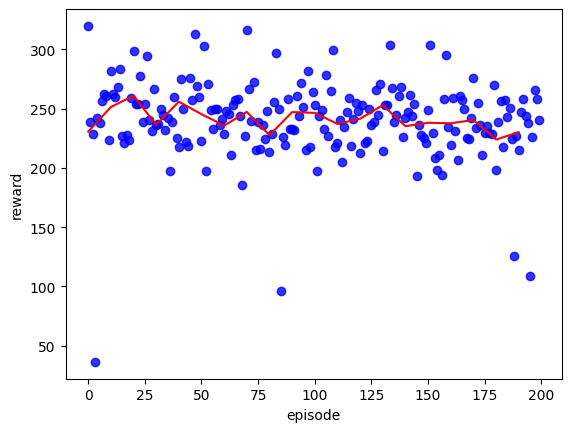

In [11]:
DDQN.run(train = False, verbose = True, n_episodes = 200)

The game is considered solved with a mean reward of 200

In [12]:
np.mean(DDQN.rewards)

241.0237565972563